# Credit card Fraud detection

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical


from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score, precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

## Import of the dataset of credit card operations
from https://www.kaggle.com/mlg-ulb/creditcardfraud

In [28]:
df = pd.read_csv("/Users/victor_03/Documents/Man 2019-2020/Dissertation/Datasets/creditcard.csv")

y = df["Class"].values
X = df.drop(["Class", "Time"], axis=1)

x_scale = StandardScaler().fit_transform(X.values)
x_norm, x_fraud = x_scale[y == 0], x_scale[y == 1]

The dataset is composed of 31 features. Time of operation, amount of the operation and class (1=fraud, 0=non-fraud). The 28 other features are the result of a PCA on the original dataset, not available.

In [29]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Parameters for the model

In [30]:
batch_size = 256
learning_rate=0.0005
epochs=15
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

AE_train_size = 100000
LR_train_size = 100000
fraud_train_size = int(len(x_fraud)*.7)
#Validation size: last 84807 rows

X_train_AE = x_norm[:AE_train_size]
#No y_train needed for the autoencoder as it is a semi-supervised model

### Model autoencoder
We first train the autoencoder model to reconstruct the input data
The training is done using the non-fraud data only so that the model learn to reconstruct it.

In [31]:
#Autoencoder
n_feature=X_train_AE.shape[1]

i = Input(shape=(n_feature,))
x = Dense(1024, activation='relu')(i)
x = Dense(128, activation="relu")(x)
x = Dense(16, activation="relu")(x)
x = Dense(128, activation="relu")(x)
x = Dense(1024, activation="relu")(x)
o = Dense(n_feature)(x)


#Compile and fit
model = Model(i,o)
model.compile(loss="mse", metrics=['accuracy'], optimizer=optimizer)
model.summary()

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)
#The target is the input data
hist = model.fit(X_train_AE, X_train_AE, epochs=epochs, batch_size=batch_size, verbose=1, validation_split=0.1, callbacks=[callback])

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 29)]              0         
_________________________________________________________________
dense_18 (Dense)             (None, 1024)              30720     
_________________________________________________________________
dense_19 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_20 (Dense)             (None, 16)                2064      
_________________________________________________________________
dense_21 (Dense)             (None, 128)               2176      
_________________________________________________________________
dense_22 (Dense)             (None, 1024)              132096    
_________________________________________________________________
dense_23 (Dense)             (None, 29)                2972

#### Plot of the accuracy of the reconstruction model

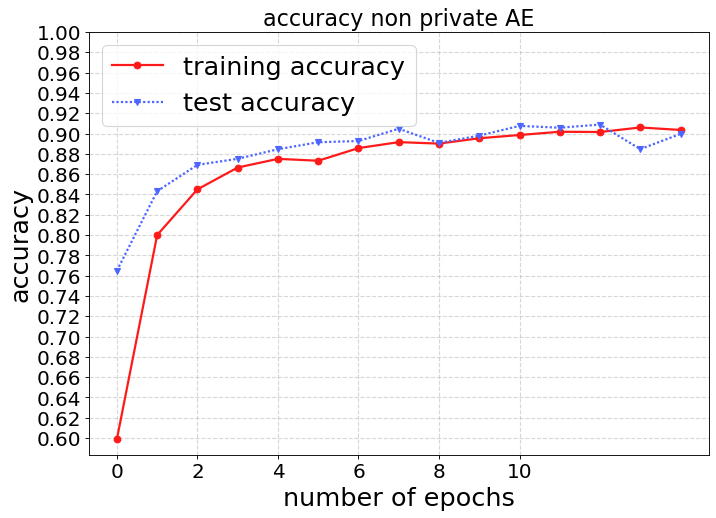

In [32]:
fig, ax = plt.subplots(figsize = (10, 7), dpi=80, facecolor='w', edgecolor='k')
ax.plot(hist.history['acc'], label="training accuracy", linewidth = 2, marker='o', color=(1, .1, .1))
ax.plot(hist.history['val_acc'], label='test accuracy', linewidth = 2, marker='v', color=(.3, .4, 1), linestyle=(0, (1, 1)))

ax.grid(alpha=.5, linewidth = 1, linestyle = '--')
ax.legend(fontsize = 23)
plt.title("accuracy non private AE", fontsize=20)
plt.xlabel("number of epochs", fontsize=23)
plt.ylabel("accuracy", fontsize=23)
plt.gca().xaxis.set_tick_params(labelsize = 18)
plt.gca().yaxis.set_tick_params(labelsize = 18)
ax.xaxis.set_ticks([2*i for i in range(0, 6)])
ax.yaxis.set_ticks([0.02*i for i in range(30, 51)])
plt.show()

## Fraud detection 
The data is reconstruct through the autoencoder. 
As fraud data input the model, the output should be largely different than expected for non-fraud data.
The distance is then calculated between the input data and its reconstruction.
The data with large distance are considered as fraud.

In [33]:
#Reconstruction of the data, non-fraud and fraud
norm_hid_rep = model.predict(x_norm)
fraud_hid_rep = model.predict(x_fraud)

#data to train the logistic regression, different than those used for the autoencoder
#Size of the training set in this case: 100,000
norm_LR_training = norm_hid_rep[AE_train_size: AE_train_size + LR_train_size]
fraud_LR_training = fraud_hid_rep[:fraud_train_size]
#The last 86704 are used for the validation
norm_LR_validation = norm_hid_rep[AE_train_size + LR_train_size:]
fraud_LR_validation = fraud_hid_rep[fraud_train_size:]

#We add the fraud data 
rep_x_train = np.append(norm_LR_training, fraud_LR_training, axis = 0)
y_n = np.zeros(norm_LR_training.shape[0])
y_f = np.ones(fraud_hid_rep[:fraud_train_size].shape[0])
#target label
rep_y_train = np.append(y_n, y_f)

### Training of the Logistic regression

In [34]:
clf = LogisticRegression(random_state=0).fit(rep_x_train, rep_y_train)

prediction = clf.predict(np.concatenate((norm_LR_validation, fraud_LR_validation), axis=0))

## Validation of the model using AUC, precision, recall and f1 score
AUC is the main parameter used for validation on this dataset. Nevertheless, it appears that some models can provide high AUC while providing poor results on performance and recall. 
f1 score thereby appears as a good second parameter to confirm the performance of the model

In [35]:
rep_x_validation = np.append(norm_LR_validation, fraud_LR_validation, axis = 0)
y_n_validation = np.zeros(norm_LR_validation.shape[0])
y_f_validation = np.ones(fraud_LR_validation[:fraud_train_size].shape[0])
ground_truth = np.append(y_n_validation, y_f_validation)


recall = recall_score(ground_truth, prediction, average=None)[1]
f1 = f1_score(ground_truth, prediction, average=None)[1]
precision = precision_score(ground_truth, prediction, average=None)[1]
print('AUC: ', roc_auc_score(ground_truth, prediction))
print('recall:', recall)
print('f1: ', f1)
print('precision: ', precision)

AUC:  0.831051430366499
recall: 0.6621621621621622
f1:  0.7808764940239044
precision:  0.9514563106796117


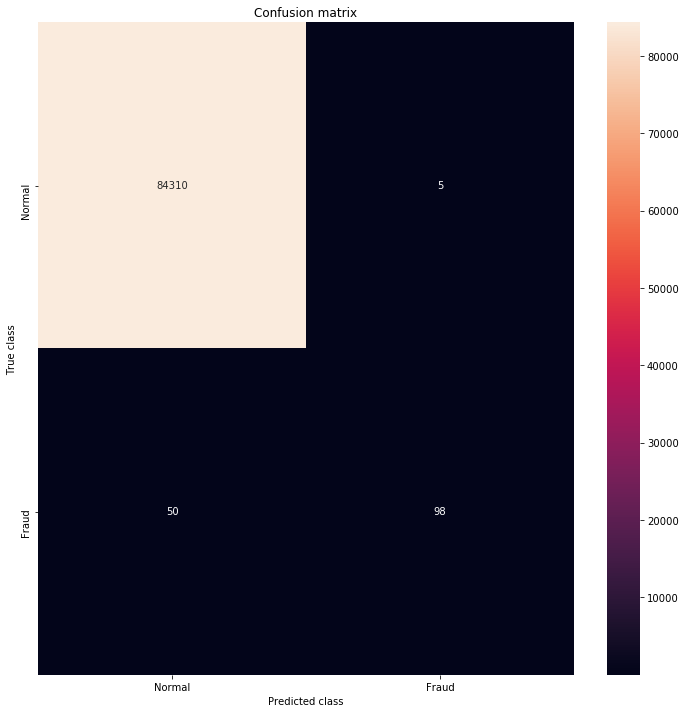

In [36]:
conf_matrix = confusion_matrix(ground_truth, prediction)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"], annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

## Comparison with a pure Logistic Regression

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [38]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

prediction = clf.predict(X_test)

/Users/victor_03/opt/anaconda3/envs/Tenv/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [39]:
recall = recall_score(y_test, prediction, average=None)[1]
f1 = f1_score(y_test, prediction, average=None)[1]
precision = precision_score(y_test, prediction, average=None)[1]
print('AUC: ', roc_auc_score(y_test, prediction))
print('recall:', recall)
print('f1: ', f1)
print('precision: ', precision)

AUC:  0.8052112663958441
recall: 0.6106194690265486
f1:  0.7040816326530611
precision:  0.8313253012048193


To conclude, a pure logistic regression provides results sensibly lower than when a autoencoder is previously applied